# Prediction of the engrgy consummation for buildings in the city of Settle


## Project description


- Prediction  of the engry consumation and the CO2 total emission per building with the help of supervised machine learning models
- Creation of a pipeline for cleaning the data 
- Train different machine learning algorithms 
- Hyperparameters optimization
- Calculation of the importance of each feature
- Using of ensemble algorithm

data source : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

# Import data

In [1]:
!pip install missingno

In [2]:
!pip install eli5

In [3]:
import pandas as pd
import missingno as msno
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec 
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import folium
from folium.plugins import FastMarkerCluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


We have two datasets, one of the year 2015 and the second from 2016.

In [4]:
# Import data
data_2015 = pd.read_csv('Data/2015-building-energy-benchmarking.csv', sep=',', encoding = 'utf-8')
data_2016 = pd.read_csv('Data/2016-building-energy-benchmarking.csv', sep=',', encoding = 'utf-8')

In [5]:
data_2015.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

The datasets containts differents information.Some of the them related directly to the buildings (e.g. building type, the construction year and the other properties). It contains information about the neighborhood, postal code in addition to the different kind of energy consumation (e.g. Electricity, natural gas, steam and other fuels).


In this project the main objectif is to predict the total consumation of energy of the buildings without the help of direct features.

I selected the follow features which seems to be related to our problematic.

In [6]:
#features = ["OSEBuildingID","PropertyName","BuildingType","PrimaryPropertyType", "YearBuilt" , "NumberofFloors" , "PropertyGFATotal" , "NumberofBuildings", "PrimaryPropertyType","LargestPropertyUseTypeGFA", "TotalGHGEmissions", "SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)",'SteamUse(kBtu)','Latitude', 'Longitude',"CouncilDistrictCode"]
features = ["OSEBuildingID","PropertyName","BuildingType","PrimaryPropertyType", "YearBuilt" , "NumberofFloors" , 
            "PropertyGFATotal" , "NumberofBuildings", "PrimaryPropertyType", "TotalGHGEmissions", "SiteEnergyUse(kBtu)",
            "PropertyGFAParking","LargestPropertyUseTypeGFA","LargestPropertyUseType","SecondLargestPropertyUseTypeGFA",
            "NaturalGas(kBtu)","Electricity(kBtu)",'SteamUse(kBtu)','Latitude', 'Longitude',"CouncilDistrictCode"
           ]

data16 = data_2016[features]

In [7]:
data16.head(2)

OSEBuildingID          PropertyName    BuildingType PrimaryPropertyType  \
0              1  Mayflower park hotel  NonResidential               Hotel   
1              2       Paramount Hotel  NonResidential               Hotel   

   YearBuilt  NumberofFloors  PropertyGFATotal  NumberofBuildings  \
0       1927              12             88434                1.0   
1       1996              11            103566                1.0   

  PrimaryPropertyType  TotalGHGEmissions  ...  PropertyGFAParking  \
0               Hotel             249.98  ...                   0   
1               Hotel             295.86  ...               15064   

   LargestPropertyUseTypeGFA  LargestPropertyUseType  \
0                    88434.0                   Hotel   
1                    83880.0                   Hotel   

  SecondLargestPropertyUseTypeGFA  NaturalGas(kBtu)  Electricity(kBtu)  \
0                             NaN         1276453.0          3946027.0   
1                         15064.0         5145082.0          3242851.0   

   SteamUse(kBtu)  Latitude  Longitude  CouncilDistrictCode  
0       2003882.0  47.61220 -122.33799                    7  
1             0.0  47.61317 -122.33393                    7  

[2 rows x 21 columns]

In [8]:
#features = ["OSEBuildingID","PropertyName","BuildingType", "YearBuilt" , "NumberofFloors","PrimaryPropertyType" , "PropertyGFATotal" , "NumberofBuildings", "PrimaryPropertyType","LargestPropertyUseTypeGFA", "GHGEmissions(MetricTonsCO2e)", "SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","SteamUse(kBtu)","OtherFuelUse(kBtu)", "CouncilDistrictCode"]

features = ["OSEBuildingID","PropertyName","BuildingType", "YearBuilt" , "NumberofFloors","PrimaryPropertyType" , 
            "PropertyGFATotal" , "NumberofBuildings", "PrimaryPropertyType","LargestPropertyUseTypeGFA","SecondLargestPropertyUseTypeGFA",
            "PropertyGFAParking","LargestPropertyUseTypeGFA","LargestPropertyUseType",
            "GHGEmissions(MetricTonsCO2e)", "SiteEnergyUse(kBtu)","NaturalGas(kBtu)","Electricity(kBtu)","SteamUse(kBtu)","OtherFuelUse(kBtu)", "CouncilDistrictCode"]


data15 = data_2015[features]
data15 = data15.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions'})
     

In [9]:
data15.head(2)

OSEBuildingID          PropertyName    BuildingType  YearBuilt  \
0              1  MAYFLOWER PARK HOTEL  NonResidential       1927   
1              2       PARAMOUNT HOTEL  NonResidential       1996   

   NumberofFloors PrimaryPropertyType  PropertyGFATotal  NumberofBuildings  \
0            12.0               Hotel             88434                  1   
1            11.0               Hotel            103566                  1   

  PrimaryPropertyType  LargestPropertyUseTypeGFA  ...  PropertyGFAParking  \
0               Hotel                    88434.0  ...                   0   
1               Hotel                    83880.0  ...               15064   

   LargestPropertyUseTypeGFA  LargestPropertyUseType TotalGHGEmissions  \
0                    88434.0                   Hotel            249.43   
1                    83880.0                   Hotel            263.51   

   SiteEnergyUse(kBtu)  NaturalGas(kBtu)  Electricity(kBtu)  SteamUse(kBtu)  \
0            6981428.0         1272388.0          3686160.0       2023032.0   
1            8354235.0         4448985.0          3905411.0             0.0   

   OtherFuelUse(kBtu)  CouncilDistrictCode  
0                 0.0                    7  
1                 0.0                    7  

[2 rows x 21 columns]

# Data cleaning

In [10]:
print('The columns available on the 2015 dataset only: \n\n', set(data_2015.columns) - set(data_2016.columns))


The columns available on the 2015 dataset only: 

 {'2010 Census Tracts', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'SPD Beats', 'GHGEmissions(MetricTonsCO2e)', 'Seattle Police Department Micro Community Policing Plan Areas', 'Comment', 'OtherFuelUse(kBtu)', 'City Council Districts', 'Location', 'Zip Codes'}


In [11]:
print('\nThe columns available on the 2016 dataset only: \n\n', set(data_2016.columns) - set(data_2015.columns))


The columns available on the 2016 dataset only: 

 {'TotalGHGEmissions', 'Comments', 'ZipCode', 'Address', 'GHGEmissionsIntensity', 'City', 'Latitude', 'State', 'Longitude'}


### Grouping the two datasets

In [12]:
data15['PropertyName_lower'] = data15['PropertyName'].str.lower()
data16['PropertyName_lower'] = data16['PropertyName'].str.lower()
data15 = pd.merge(data15, data16[['PropertyName_lower','Latitude', 'Longitude']],how="left", on="PropertyName_lower")
data16 = pd.merge(data16, data15[['PropertyName_lower','OtherFuelUse(kBtu)']],how="left", on="PropertyName_lower")


<ipython-input-12-7122b479040b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data16['PropertyName_lower'] = data16['PropertyName'].str.lower()


In [13]:
data15.shape

(3350, 24)

In [14]:
data16.shape

(3416, 23)

In [15]:
d14, d15 = data15.set_index('OSEBuildingID').align(data16.set_index('OSEBuildingID'), 'inner')

frames = [data15, data16]

#comb_data = pd.concat(frames)
comb_data = d14.append(d15).reset_index()

In [16]:
comb_data.shape

(6720, 26)

In [17]:
comb_data.head(2)

OSEBuildingID    BuildingType  CouncilDistrictCode  Electricity(kBtu)  \
0              1  NonResidential                    7          3686160.0   
1              2  NonResidential                    7          3905411.0   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   

   LargestPropertyUseTypeGFA  Latitude  Longitude  NaturalGas(kBtu)  ...  \
0                    88434.0  47.61220 -122.33799         1272388.0  ...   
1                    83880.0  47.61317 -122.33393         4448985.0  ...   

   PrimaryPropertyType  PropertyGFAParking  PropertyGFATotal  \
0                Hotel                   0             88434   
1                Hotel               15064            103566   

           PropertyName    PropertyName_lower SecondLargestPropertyUseTypeGFA  \
0  MAYFLOWER PARK HOTEL  mayflower park hotel                             NaN   
1       PARAMOUNT HOTEL       paramount hotel                         15064.0   

  SiteEnergyUse(kBtu)  SteamUse(kBtu)  TotalGHGEmissions YearBuilt  
0           6981428.0       2023032.0             249.43      1927  
1           8354235.0             0.0             263.51      1996  

[2 rows x 26 columns]

In [18]:
comb_data = comb_data.loc[:,~comb_data.columns.duplicated()]

In [19]:
comb_data.columns

Index(['OSEBuildingID', 'BuildingType', 'CouncilDistrictCode',
       'Electricity(kBtu)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'Latitude', 'Longitude',
       'NaturalGas(kBtu)', 'NumberofBuildings', 'NumberofFloors',
       'OtherFuelUse(kBtu)', 'PrimaryPropertyType', 'PropertyGFAParking',
       'PropertyGFATotal', 'PropertyName', 'PropertyName_lower',
       'SecondLargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'TotalGHGEmissions', 'YearBuilt'],
      dtype='object')

### Data featuring

#### Target variables 
 
The target features that we try to predict are :

    - CO2 total emission "TotalGHGEmissions"
    - Total energy consumation "SiteEnergyUseWN(kBtu)"
    
Without taking in consideration the directly energy-related feautres:

- SiteEUI(kBtu/sf)
- SiteEUIWN(kBtu/sf) 
- SourceEUI(kBtu/sf) 
- SourceEUIWN(kBtu/sf) 
- SiteEnergyUse(kBtu) 
- SiteEnergyUseWN(kBtu) 
- SteamUse(kBtu) 
- thermal units (kBtu).
- Electricity(kWh) 
- Electricity(kBtu) 
- NaturalGas(therms)
- NaturalGas(kBtu)
- OtherFuelUse(kBtu)


#### Identify potential information

Here is the list of features which could help us in our goal:
    
    - The building type "BuildingType" 
    - The year where the building is built "YearBuilt"
    - The number of floors "NumberofFloors"
    - Total Gross floor area "PropertyGFATotal"
    - Number of properties "NumberofBuildings"
    - The type of the primary property "PrimaryPropertyType"
    - The largest property "LargestPropertyUseTypeGFA"	
    

*Comb = combiend

In [20]:

comb_data["useElectricity"] = np.where(comb_data["Electricity(kBtu)"].isnull() |
                                           comb_data["Electricity(kBtu)"] == 0, 0, 1)

comb_data["useNaturalGas"] = np.where(comb_data["NaturalGas(kBtu)"].isnull() |
                                          comb_data["NaturalGas(kBtu)"] ==0, 0, 1)

comb_data["useSteam"] = np.where(comb_data["SteamUse(kBtu)"].isnull() |
                                     comb_data["SteamUse(kBtu)"] == 0, 0, 1)

comb_data["useOtherFuel"] = np.where(comb_data["OtherFuelUse(kBtu)"].isnull() |
                                         comb_data["OtherFuelUse(kBtu)"] == 0, 0, 1)


In [21]:
comb_data.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)','OtherFuelUse(kBtu)'], axis=1,inplace =True)


In [22]:
comb_data.sample(2)

OSEBuildingID          BuildingType  CouncilDistrictCode  \
1825          23409  Multifamily MR (5-9)                    3   
6024          26237        NonResidential                    2   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  Latitude  Longitude  \
1825    Multifamily Housing                    51900.0       NaN        NaN   
6024           Retail Store                    14344.0  47.56555 -122.33362   

      NumberofBuildings  NumberofFloors   PrimaryPropertyType  ...  \
1825                1.0             5.0  Mid-Rise Multifamily  ...   
6024                1.0             1.0    Mixed Use Property  ...   

          PropertyName  PropertyName_lower SecondLargestPropertyUseTypeGFA  \
1825   CHASSELTON APTS     chasselton apts                             NaN   
6024  Daniel Smith Inc    daniel smith inc                         10272.0   

     SiteEnergyUse(kBtu)  TotalGHGEmissions  YearBuilt  useElectricity  \
1825          2656729.00             119.97       1925               1   
6024          1992158.25              46.01       1947               1   

      useNaturalGas  useSteam  useOtherFuel  
1825              1         0             0  
6024              1         0             1  

[2 rows x 22 columns]

### Delete of duplicated values

In [23]:
comb_data.shape

(6720, 22)

In [24]:
comb_data = comb_data.drop_duplicates(subset =['PropertyName_lower','SiteEnergyUse(kBtu)','TotalGHGEmissions'], keep ='first')


In [25]:
comb_data.sort_values('OSEBuildingID').head(3).sample(10, replace=True)

OSEBuildingID    BuildingType  CouncilDistrictCode  \
3360              1  NonResidential                    7   
1                 2  NonResidential                    7   
3360              1  NonResidential                    7   
0                 1  NonResidential                    7   
1                 2  NonResidential                    7   
0                 1  NonResidential                    7   
0                 1  NonResidential                    7   
3360              1  NonResidential                    7   
1                 2  NonResidential                    7   
1                 2  NonResidential                    7   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  Latitude  Longitude  \
3360                  Hotel                    88434.0  47.61220 -122.33799   
1                     Hotel                    83880.0  47.61317 -122.33393   
3360                  Hotel                    88434.0  47.61220 -122.33799   
0                     Hotel                    88434.0  47.61220 -122.33799   
1                     Hotel                    83880.0  47.61317 -122.33393   
0                     Hotel                    88434.0  47.61220 -122.33799   
0                     Hotel                    88434.0  47.61220 -122.33799   
3360                  Hotel                    88434.0  47.61220 -122.33799   
1                     Hotel                    83880.0  47.61317 -122.33393   
1                     Hotel                    83880.0  47.61317 -122.33393   

      NumberofBuildings  NumberofFloors PrimaryPropertyType  ...  \
3360                1.0            12.0               Hotel  ...   
1                   1.0            11.0               Hotel  ...   
3360                1.0            12.0               Hotel  ...   
0                   1.0            12.0               Hotel  ...   
1                   1.0            11.0               Hotel  ...   
0                   1.0            12.0               Hotel  ...   
0                   1.0            12.0               Hotel  ...   
3360                1.0            12.0               Hotel  ...   
1                   1.0            11.0               Hotel  ...   
1                   1.0            11.0               Hotel  ...   

              PropertyName    PropertyName_lower  \
3360  Mayflower park hotel  mayflower park hotel   
1          PARAMOUNT HOTEL       paramount hotel   
3360  Mayflower park hotel  mayflower park hotel   
0     MAYFLOWER PARK HOTEL  mayflower park hotel   
1          PARAMOUNT HOTEL       paramount hotel   
0     MAYFLOWER PARK HOTEL  mayflower park hotel   
0     MAYFLOWER PARK HOTEL  mayflower park hotel   
3360  Mayflower park hotel  mayflower park hotel   
1          PARAMOUNT HOTEL       paramount hotel   
1          PARAMOUNT HOTEL       paramount hotel   

     SecondLargestPropertyUseTypeGFA SiteEnergyUse(kBtu)  TotalGHGEmissions  \
3360                             NaN           7226362.5             249.98   
1                            15064.0           8354235.0             263.51   
3360                             NaN           7226362.5             249.98   
0                                NaN           6981428.0             249.43   
1                            15064.0           8354235.0             263.51   
0                                NaN           6981428.0             249.43   
0                                NaN           6981428.0             249.43   
3360                             NaN           7226362.5             249.98   
1                            15064.0           8354235.0             263.51   
1                            15064.0           8354235.0             263.51   

      YearBuilt  useElectricity  useNaturalGas  useSteam  useOtherFuel  
3360       1927               1              1         1             0  
1          1996               1              1         0             0  
3360       1927               1              1         1        

In [26]:
comb_data.shape

(6567, 22)

### Missing values

In [27]:
msno.bar(comb_data)

<AxesSubplot:>

In [28]:
comb_data.isna().sum().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of OSEBuildingID                         0
BuildingType                          0
CouncilDistrictCode                   0
LargestPropertyUseType              136
LargestPropertyUseTypeGFA           136
Latitude                           2399
Longitude                          2399
NumberofBuildings                     6
NumberofFloors                        8
PrimaryPropertyType                   0
PropertyGFAParking                    0
PropertyGFATotal                      0
PropertyName                          0
PropertyName_lower                    0
SecondLargestPropertyUseTypeGFA    3401
SiteEnergyUse(kBtu)                  12
TotalGHGEmissions                    15
YearBuilt                             0
useElectricity                        0
useNaturalGas                         0
useSteam                              0
useOtherFuel                          0
dtype: int64>

In [29]:
#remplacement des "faux NaN" en NaN de pandas
#Replacing the false "Nan" with Pandas Nan
comb_data = comb_data.replace(to_replace = '^nan$', value = np.nan, regex=True)

#Impute missing value with mean
comb_data = comb_data.fillna(comb_data.mean()) 

In [30]:
comb_data.isna().sum().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of OSEBuildingID                        0
BuildingType                         0
CouncilDistrictCode                  0
LargestPropertyUseType             136
LargestPropertyUseTypeGFA            0
Latitude                             0
Longitude                            0
NumberofBuildings                    0
NumberofFloors                       0
PrimaryPropertyType                  0
PropertyGFAParking                   0
PropertyGFATotal                     0
PropertyName                         0
PropertyName_lower                   0
SecondLargestPropertyUseTypeGFA      0
SiteEnergyUse(kBtu)                  0
TotalGHGEmissions                    0
YearBuilt                            0
useElectricity                       0
useNaturalGas                        0
useSteam                             0
useOtherFuel                         0
dtype: int64>

### Outliers

In [31]:
def delete_outliers_percentiles(df):
    '''Suppression des outliers du centile extrême'''
    Q1 = df.quantile(0.1)
    Q3 = df.quantile(0.9)
    IQR = Q3 - Q1

    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [32]:
comb_data.shape

(6567, 22)

In [33]:
clean_data = delete_outliers_percentiles(comb_data)

<ipython-input-31-d1a01ce3bf77>:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
<ipython-input-31-d1a01ce3bf77>:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [34]:
clean_data.shape

(5570, 22)

In [35]:
clean_data.head(3)

OSEBuildingID        BuildingType  CouncilDistrictCode  \
1              2      NonResidential                    7   
5              9  Nonresidential COS                    7   
6             10      NonResidential                    7   

  LargestPropertyUseType  LargestPropertyUseTypeGFA   Latitude   Longitude  \
1                  Hotel                    83880.0  47.613170 -122.333930   
5         Police Station                    88830.0  47.623444 -122.334846   
6                  Hotel                    81352.0  47.623444 -122.334846   

   NumberofBuildings  NumberofFloors PrimaryPropertyType  ...  \
1                1.0            11.0               Hotel  ...   
5                1.0             2.0               Other  ...   
6                1.0            11.0               Hotel  ...   

                     PropertyName              PropertyName_lower  \
1                 PARAMOUNT HOTEL                 paramount hotel   
5  WEST PRECINCT (SEATTLE POLICE)  west precinct (seattle police)   
6          CAMLIN WORLDMARK HOTEL          camlin worldmark hotel   

  SecondLargestPropertyUseTypeGFA SiteEnergyUse(kBtu)  TotalGHGEmissions  \
1                    15064.000000           8354235.0             263.51   
5                    27677.503884          12051984.0             304.62   
6                    27677.503884           6252842.0             208.46   

   YearBuilt  useElectricity  useNaturalGas  useSteam  useOtherFuel  
1       1996               1              1         0             0  
5       1999               1              1         0             0  
6       1926               1              1         0             0  

[3 rows x 22 columns]

# Exploratory data analysis (EDA)

## Univariate analysis

In [36]:
clean_data.head(3)

OSEBuildingID        BuildingType  CouncilDistrictCode  \
1              2      NonResidential                    7   
5              9  Nonresidential COS                    7   
6             10      NonResidential                    7   

  LargestPropertyUseType  LargestPropertyUseTypeGFA   Latitude   Longitude  \
1                  Hotel                    83880.0  47.613170 -122.333930   
5         Police Station                    88830.0  47.623444 -122.334846   
6                  Hotel                    81352.0  47.623444 -122.334846   

   NumberofBuildings  NumberofFloors PrimaryPropertyType  ...  \
1                1.0            11.0               Hotel  ...   
5                1.0             2.0               Other  ...   
6                1.0            11.0               Hotel  ...   

                     PropertyName              PropertyName_lower  \
1                 PARAMOUNT HOTEL                 paramount hotel   
5  WEST PRECINCT (SEATTLE POLICE)  west precinct (seattle police)   
6          CAMLIN WORLDMARK HOTEL          camlin worldmark hotel   

  SecondLargestPropertyUseTypeGFA SiteEnergyUse(kBtu)  TotalGHGEmissions  \
1                    15064.000000           8354235.0             263.51   
5                    27677.503884          12051984.0             304.62   
6                    27677.503884           6252842.0             208.46   

   YearBuilt  useElectricity  useNaturalGas  useSteam  useOtherFuel  
1       1996               1              1         0             0  
5       1999               1              1         0             0  
6       1926               1              1         0             0  

[3 rows x 22 columns]

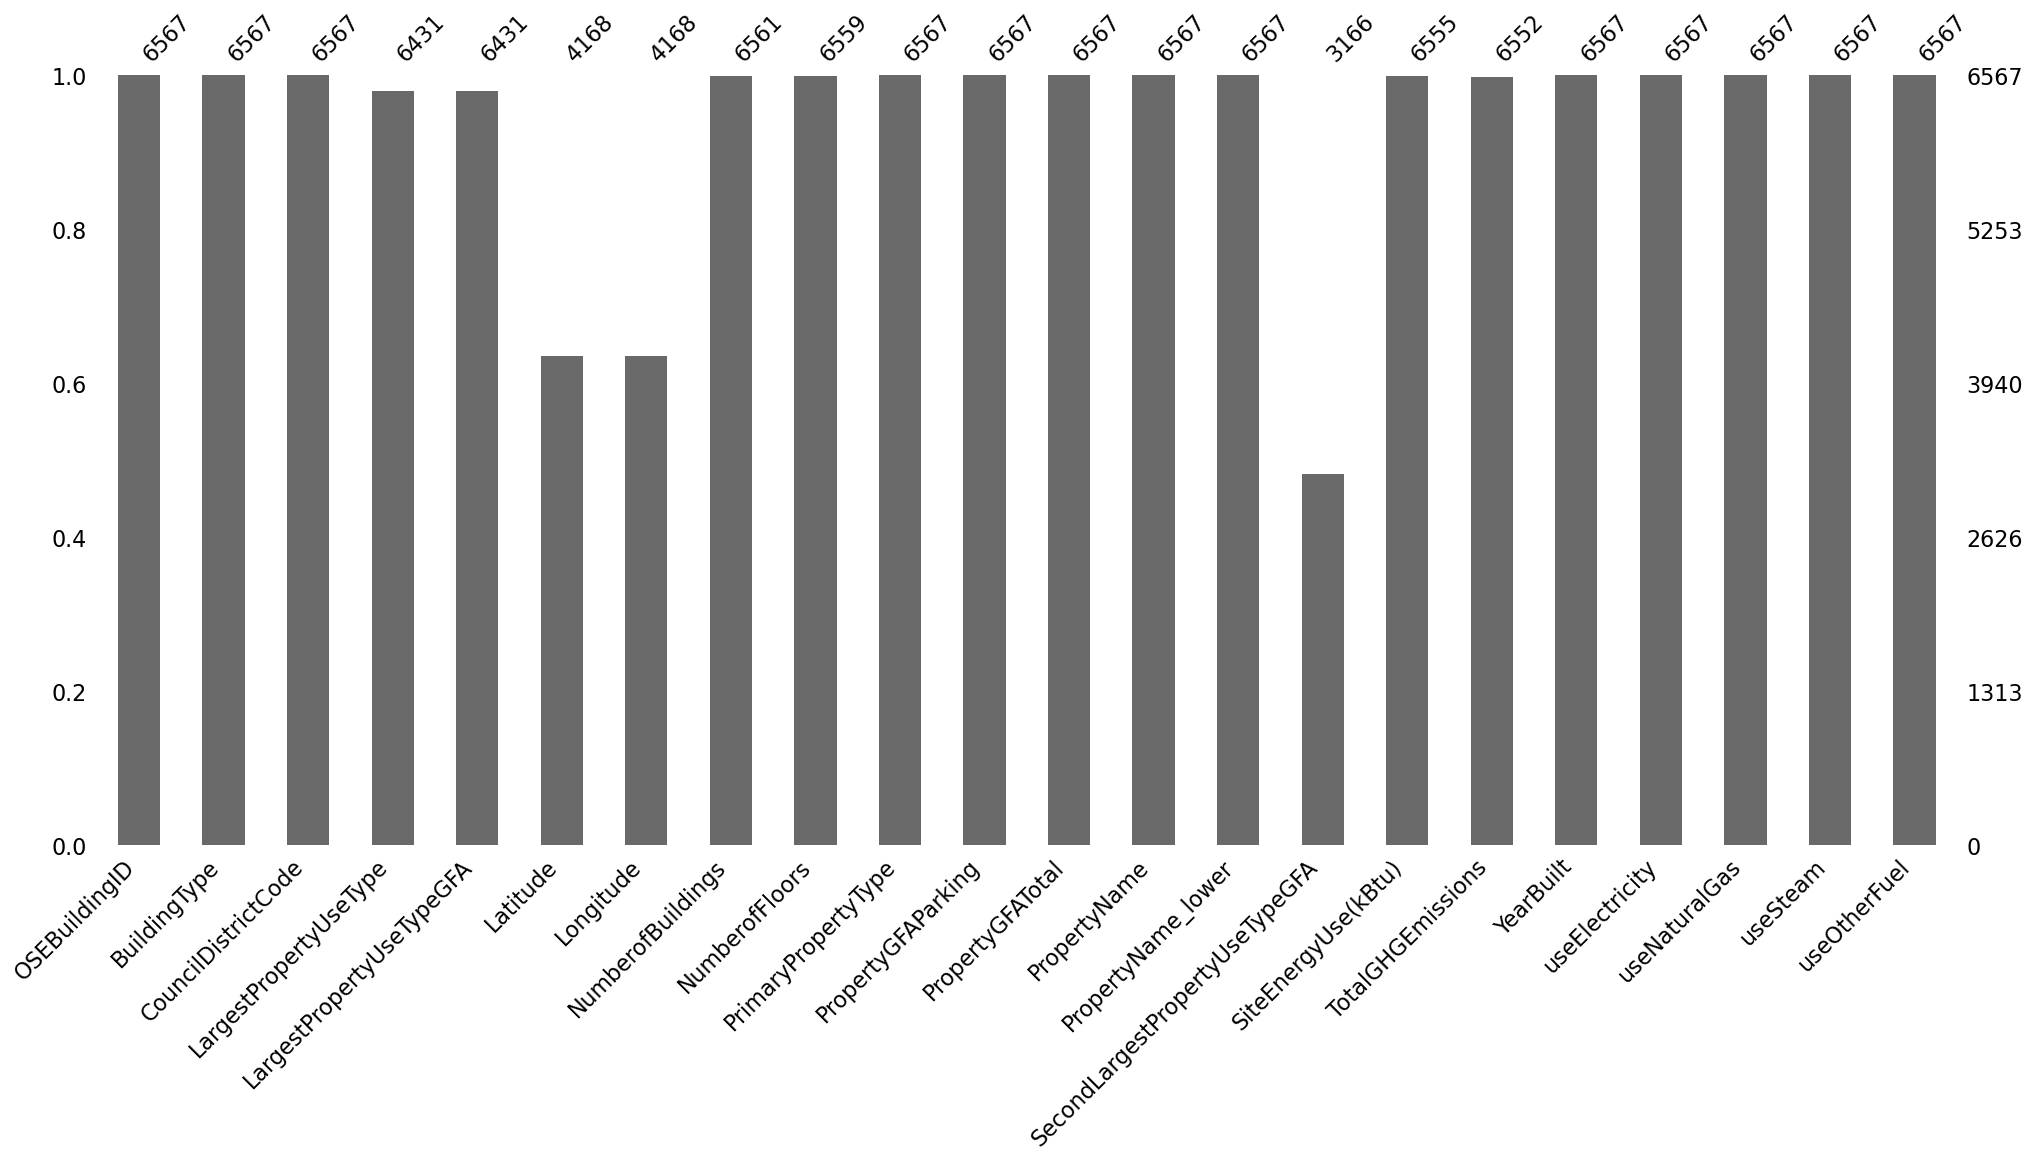

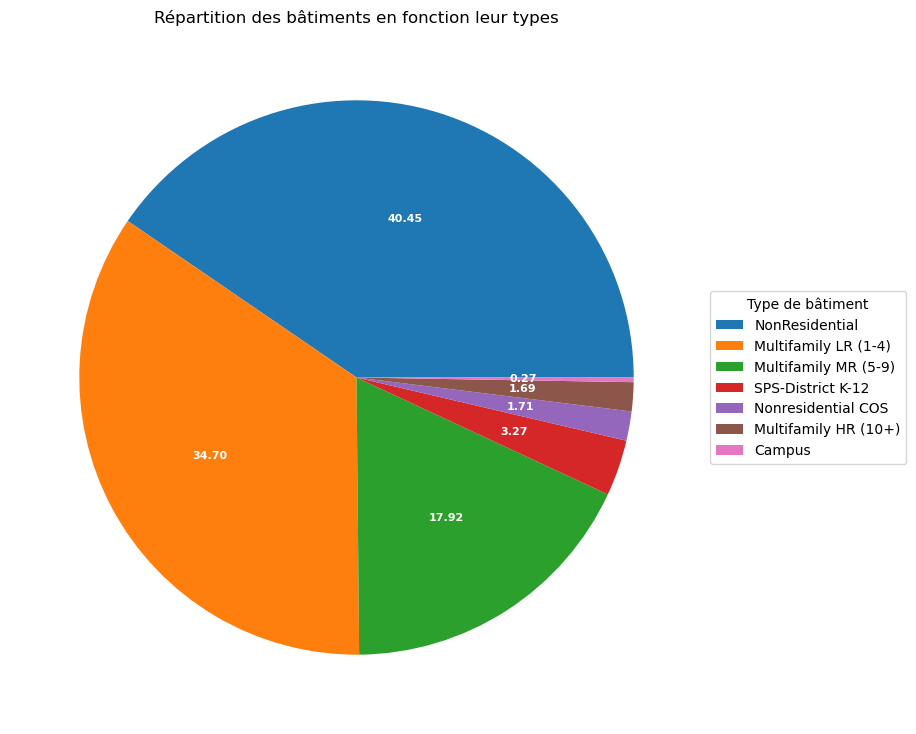

In [37]:
fig, ax = plt.subplots(figsize=(18, 9), subplot_kw=dict(aspect="equal"))

viz =clean_data["BuildingType"].value_counts()
category_prod = viz.index





wedges, texts, autotexts = ax.pie(viz, autopct='%.2f',
                                  textprops=dict(color="w"))

ax.legend(wedges, category_prod,
          title="Type de bâtiment",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Répartition des bâtiments en fonction leur types")

plt.show()

As we can see, the non residentail buildings represent the major part of our data. Multifamily residences come at the second place. I will split the data into two types (residential and no-residential builings).


In [38]:
residential = ['Multifamily LR (1-4)','Multifamily HR (10+)','Multifamily MR (5-9)']
residential_buildings = clean_data[clean_data['BuildingType'].isin(residential)]

nonResidentialBuilding = clean_data[~clean_data['BuildingType'].isin(residential)]
nonResidentialBuilding.sample(5)

OSEBuildingID       BuildingType  CouncilDistrictCode  \
2580          25956  SPS-District K-12                    3   
919           20182     NonResidential                    4   
3808            592     NonResidential                    2   
791           19847     NonResidential                    4   
85              125  SPS-District K-12                    2   

     LargestPropertyUseType  LargestPropertyUseTypeGFA   Latitude   Longitude  \
2580            K-12 School                    38297.0  47.623444 -122.334846   
919        Worship Facility                    26386.0  47.623444 -122.334846   
3808                  Other                    51427.0  47.557870 -122.335000   
791            Retail Store                    25562.0  47.623444 -122.334846   
85              K-12 School                   132060.0  47.623444 -122.334846   

      NumberofBuildings  NumberofFloors PrimaryPropertyType  ...  \
2580                1.0             3.0         K-12 School  ...   
919                 1.0             1.0    Worship Facility  ...   
3808                1.0             1.0               Other  ...   
791                 1.0             2.0        Retail Store  ...   
85                  1.0             1.0         K-12 School  ...   

                              PropertyName  \
2580               MCGILVRA (SPS-DISTRICT)   
919                      ST BRIDGET CHURCH   
3808                   SEATTLE 1ST AVE GAR   
791         UNIVERSITY VILLAGE EAST BLDG N   
85    MERCER JR HIGH SCHOOL (SPS-DISTRICT)   

                        PropertyName_lower SecondLargestPropertyUseTypeGFA  \
2580               mcgilvra (sps-district)                    27677.503884   
919                      st bridget church                        0.000000   
3808                   seattle 1st ave gar                    27677.503884   
791         university village east bldg n                      300.000000   
85    mercer jr high school (sps-district)                    27677.503884   

     SiteEnergyUse(kBtu)  TotalGHGEmissions  YearBuilt  useElectricity  \
2580           2057679.0              82.92       1925               1   
919             790204.0              25.90       1972               1   
3808           1770027.5              49.90       2000               1   
791            5462958.0             177.74       1956               1   
85             5851209.0             211.49       1957               1   

      useNaturalGas  useSteam  useOtherFuel  
2580              1         0             0  
919               1         0             0  
3808              1         0             1  
791               1         0             0  
85                1         0             0  

[5 rows x 22 columns]

### Building type

In [45]:
def histoCategVariable(data,column,rotation):
    Counts = data[column].value_counts() 
    Types = Counts.index
    
    postionofbars = list(range(len(Types)))
    plt.figure(figsize=(10, 5))
    plt.bar(postionofbars,Counts,)
    plt.xticks(postionofbars,Types, rotation= rotation)
    plt.show()

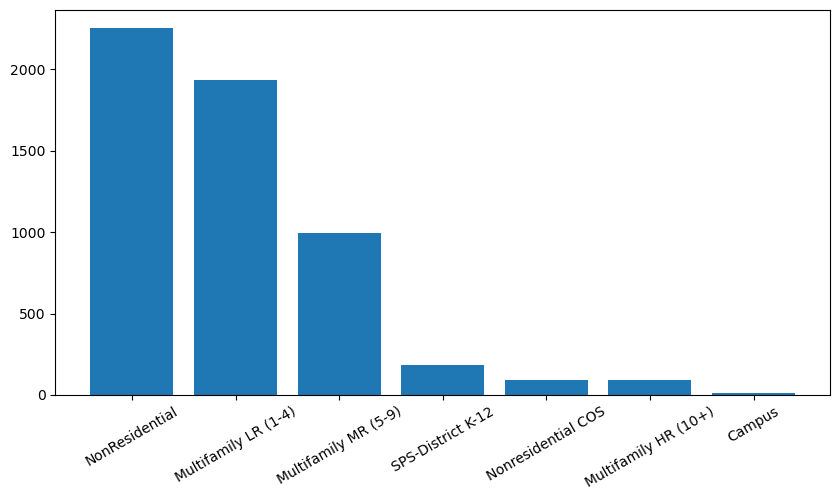

In [48]:
histoCategVariable(clean_data, "BuildingType", 30 )

### The largest primary property

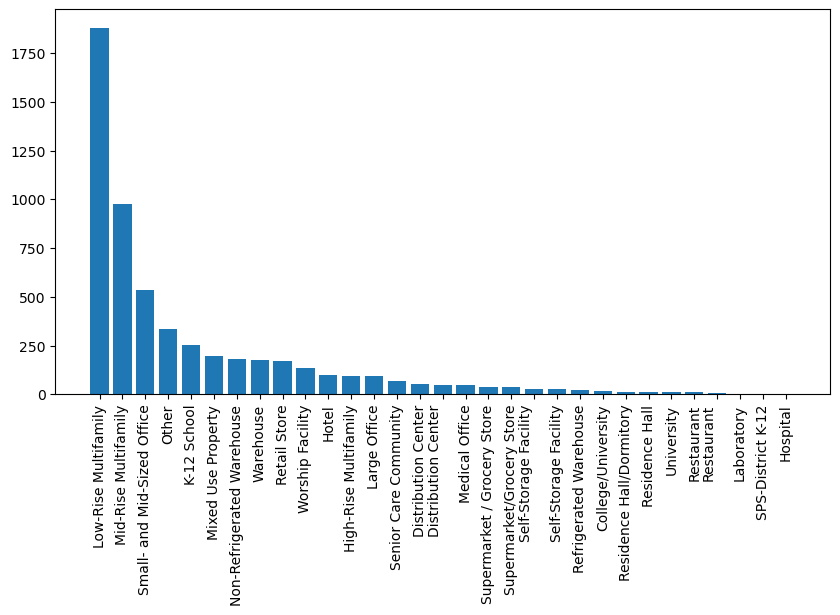

In [49]:
histoCategVariable(clean_data,"PrimaryPropertyType", 90)

<b> For the non-residential buildings: </b>

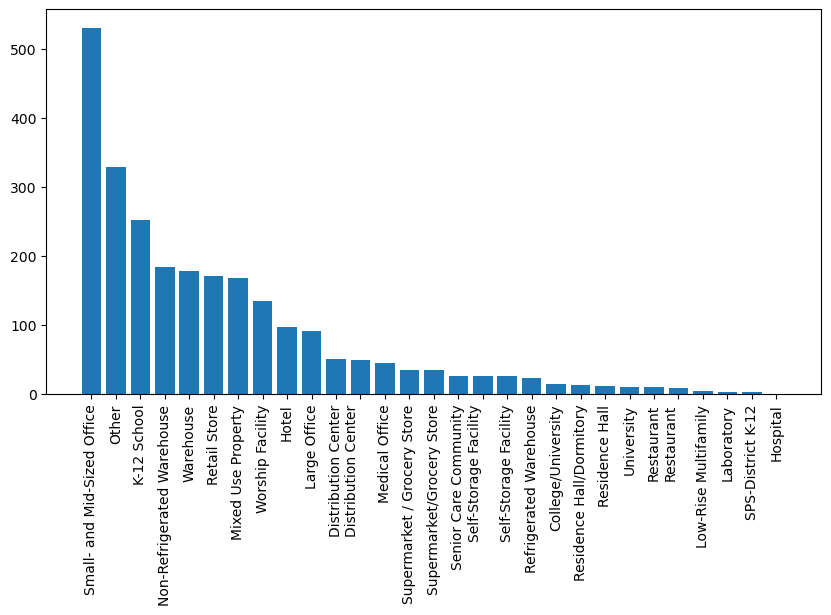

In [50]:
histoCategVariable(nonResidentialBuilding,"PrimaryPropertyType", 90)

In [56]:
def two_chart_plot(df, feature):
    fig = plt.figure(constrained_layout = True, figsize = (12, 8))
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    
    sns.distplot(df.loc[:, feature], norm_hist = True, ax = ax1)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient = 'v', ax = ax3 )
    plt.show()

### Building year

In [52]:
yearBuilt = clean_data[['OSEBuildingID','PropertyName','YearBuilt']]
yearBuilt.head(5)

OSEBuildingID                                  PropertyName  YearBuilt
1               2                               PARAMOUNT HOTEL       1996
5               9                WEST PRECINCT (SEATTLE POLICE)       1999
6              10                        CAMLIN WORLDMARK HOTEL       1926
8              12   COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE       1904
22             28  GRAHAM HILL ELEMENTARY SCHOOL (SPS-DISTRICT)       1961

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


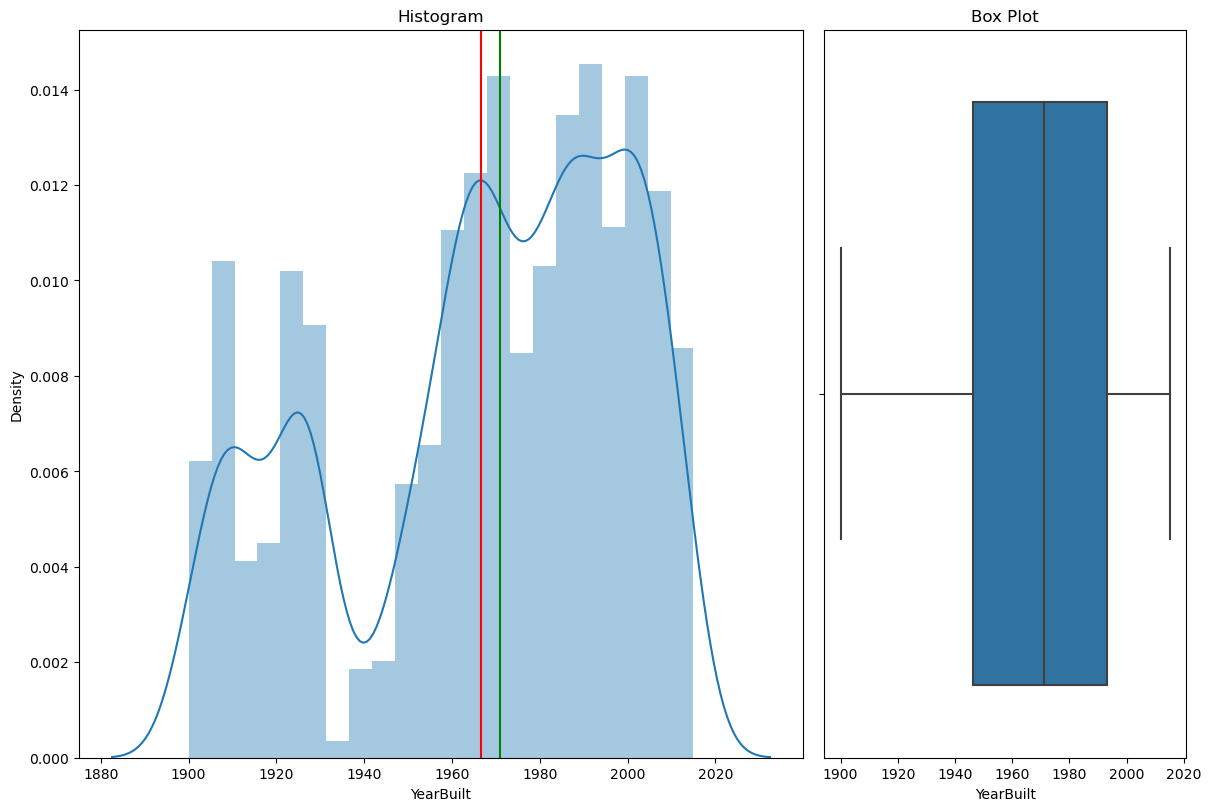

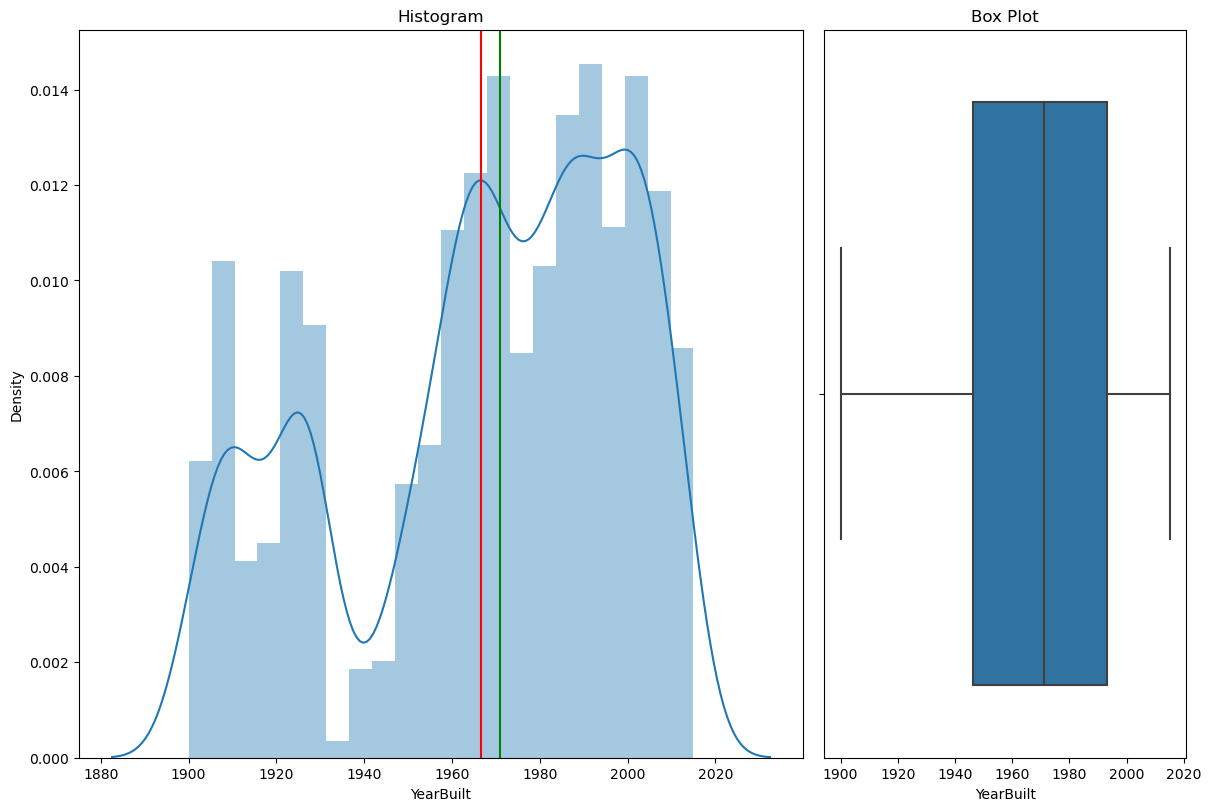

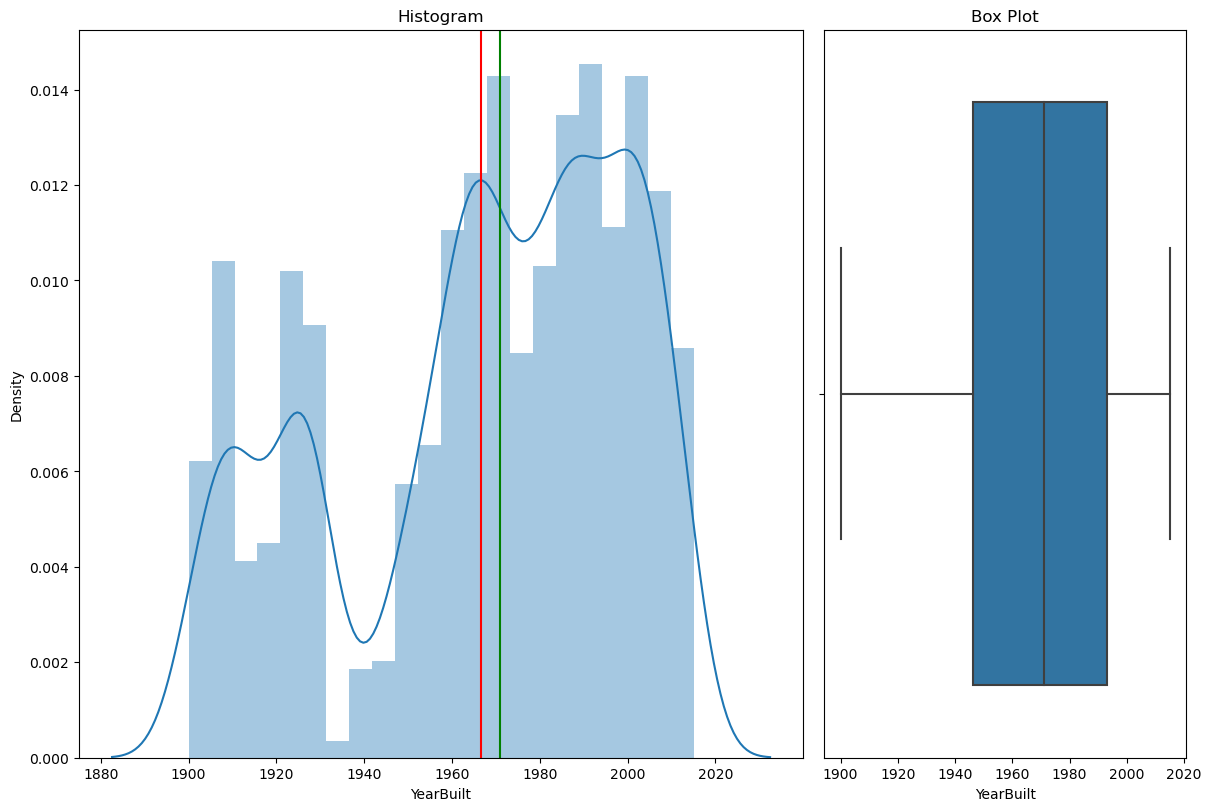

In [57]:
two_chart_plot(yearBuilt,'YearBuilt')

<b> Pour les bâtiments non résidentiel : </b>

In [46]:
nonResYearBuilt = nonResidentialBuilding[['OSEBuildingID','PropertyName','YearBuilt']]

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


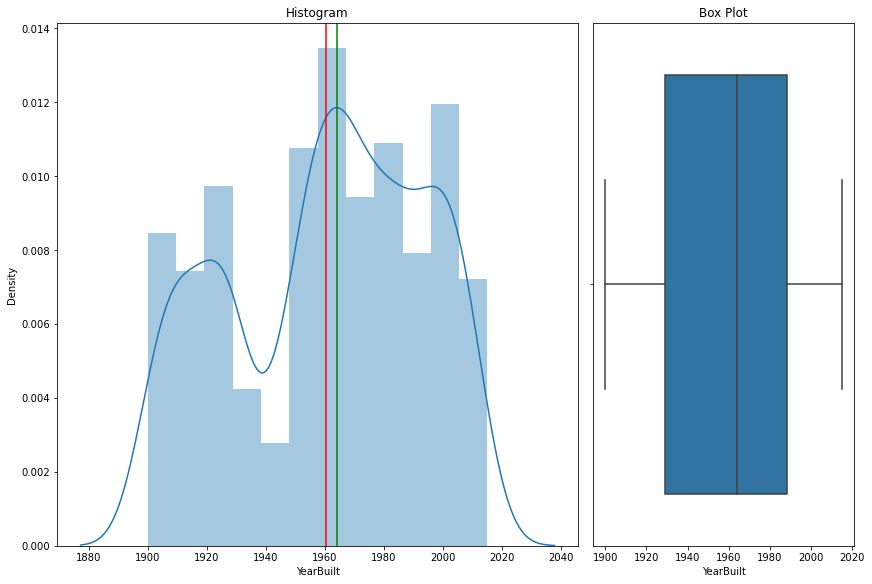

In [47]:
two_chart_plot(nonResYearBuilt,'YearBuilt')

### Nombre d'étages

In [48]:
numberFloors = clean_data[['OSEBuildingID','PropertyName','NumberofFloors']]

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


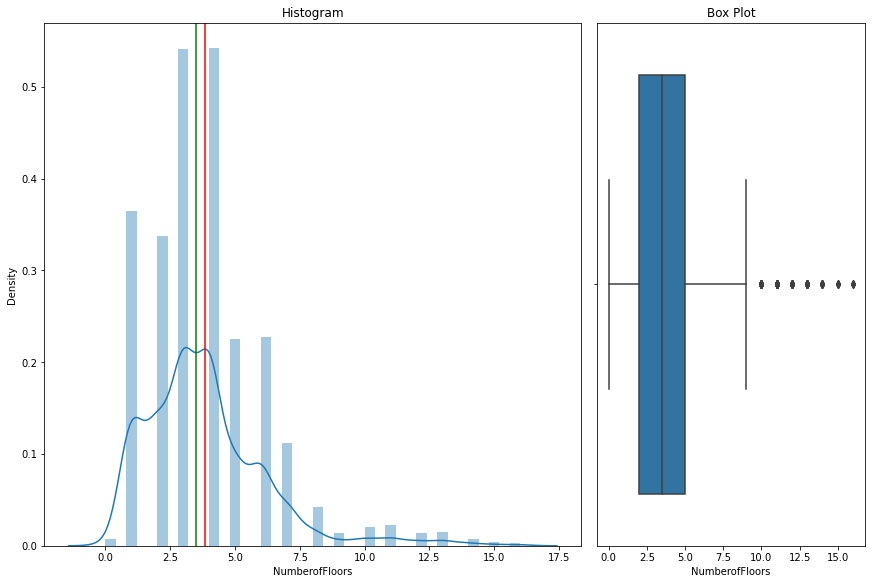

In [49]:
two_chart_plot(clean_data,'NumberofFloors')

### Surface Total

In [50]:
surfaceTotal = clean_data[['OSEBuildingID','PropertyName', 'PropertyGFATotal']]

In [51]:
surfaceTotal.sample(5)

OSEBuildingID        PropertyName  PropertyGFATotal
4344            NaN                 NaN               NaN
2448        25634.0    Acton Apartments           30169.0
3110        29448.0   Broadway Crossing           74202.0
4239            NaN                 NaN               NaN
887         20095.0  53288 - Lock Vista          159820.0

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


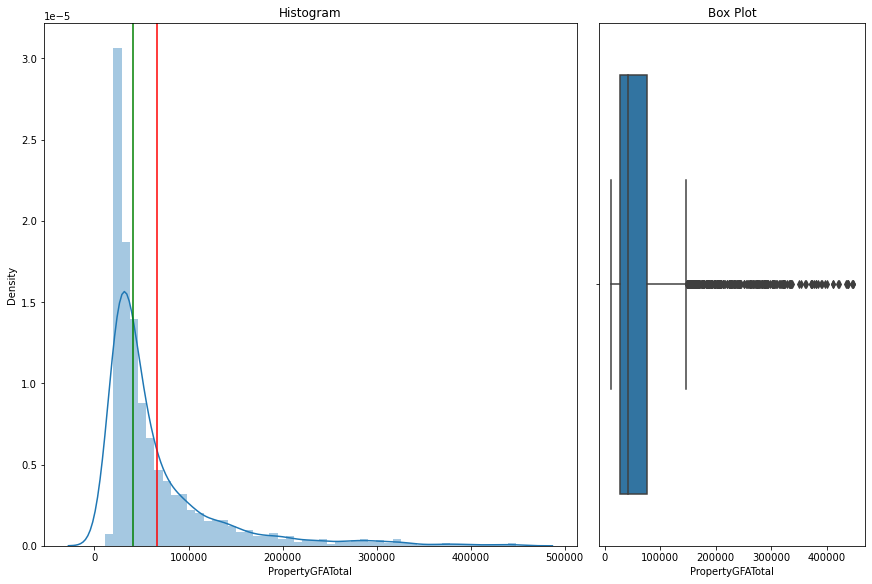

In [52]:
two_chart_plot(clean_data,"PropertyGFATotal")

### Nombre de proporités

In [53]:
clean_data["NumberofBuildings"].isna().sum().sum()

2312

In [54]:
clean_data.shape

(5489, 19)

In [55]:
nombrePropriete = clean_data[['OSEBuildingID','PropertyName','NumberofBuildings']]

In [56]:
nombrePropriete.sample(5)

OSEBuildingID              PropertyName  NumberofBuildings
4462            NaN                       NaN                1.0
3231        49858.0  The Northwest School 401                NaN
945         20274.0           Coho Apartments                1.0
4750            NaN                       NaN                1.0
4165            NaN                       NaN                1.0

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


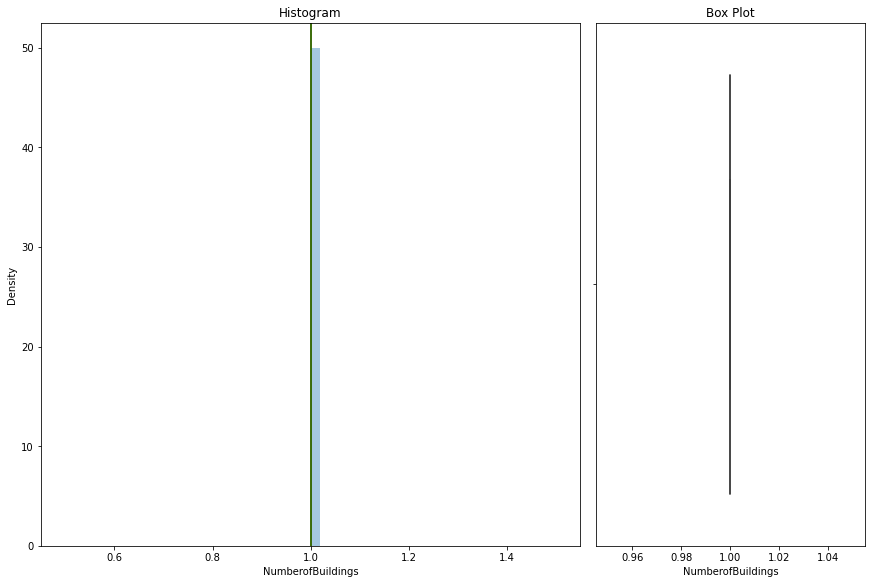

In [57]:
two_chart_plot(nombrePropriete,"NumberofBuildings")

### Plus Grande Surface

In [58]:
grandeProp = clean_data[['OSEBuildingID','PropertyName','LargestPropertyUseTypeGFA']]

In [59]:
grandeProp.sample(5)

OSEBuildingID              PropertyName  LargestPropertyUseTypeGFA
4485            NaN                       NaN                        NaN
5168            NaN                       NaN                        NaN
2615        26190.0            Ellenbert Apts                    43098.0
2508        25842.0                115 Dawson                    24000.0
2099        24393.0  Willows Court Apartments                    93472.0

D:\Anconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anconda\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


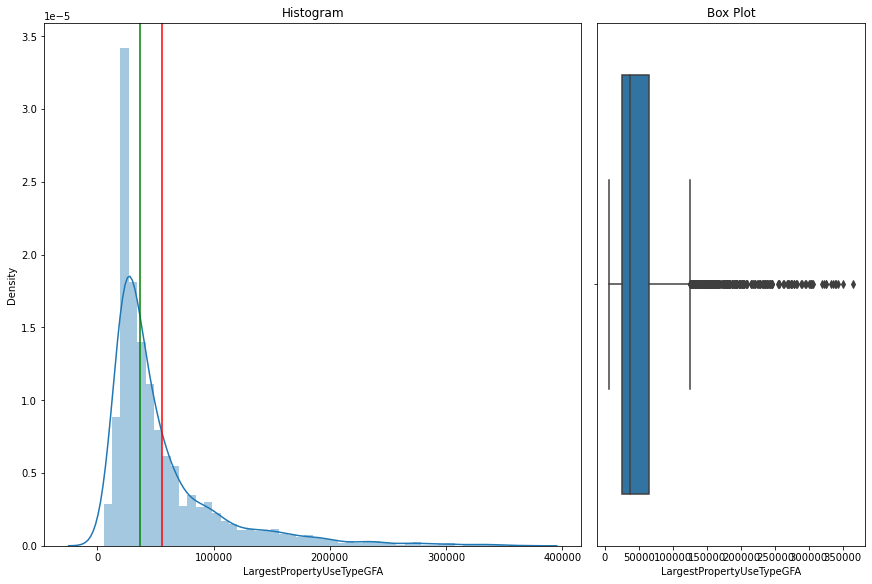

In [60]:
two_chart_plot(grandeProp,"LargestPropertyUseTypeGFA")

## Analyse Bivarié

### Type de bâtiment Vs Emission de CO2 


[Text(0, 0, 'NonResidential'),
 Text(1, 0, 'Nonresidential COS'),
 Text(2, 0, 'Multifamily MR (5-9)'),
 Text(3, 0, 'SPS-District K-12'),
 Text(4, 0, 'Campus'),
 Text(5, 0, 'Multifamily LR (1-4)'),
 Text(6, 0, 'Multifamily HR (10+)'),
 Text(7, 0, 'Nonresidential WA')]

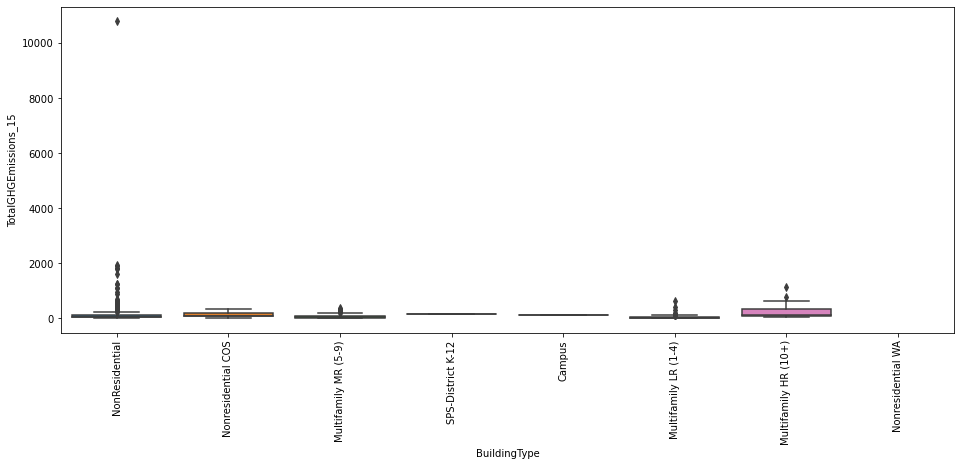

In [61]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=selected_data['BuildingType'], y=selected_data['TotalGHGEmissions_15'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


<b> La différence dans les boîtes à moustache après le nettoyage de données </b>

[Text(0, 0, 'NonResidential'),
 Text(1, 0, 'Nonresidential COS'),
 Text(2, 0, 'Multifamily MR (5-9)'),
 Text(3, 0, 'SPS-District K-12'),
 Text(4, 0, 'Multifamily LR (1-4)'),
 Text(5, 0, 'Campus'),
 Text(6, 0, 'Multifamily HR (10+)'),
 Text(7, 0, 'Nonresidential WA')]

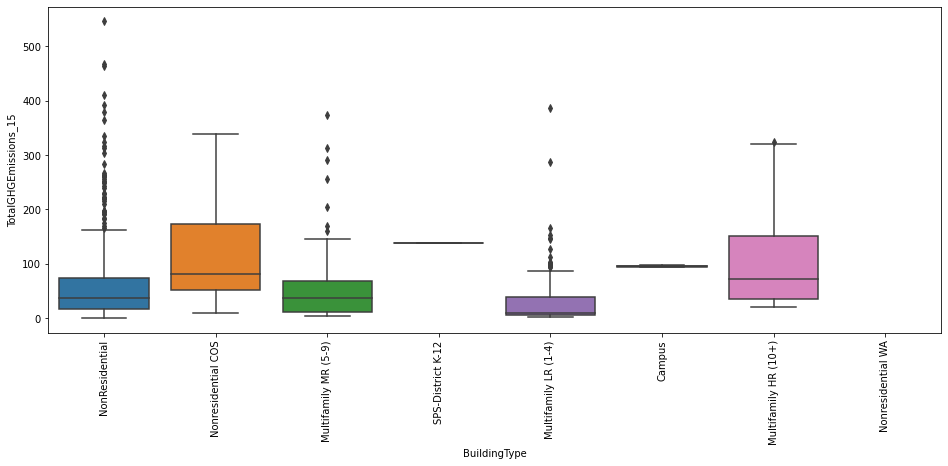

In [62]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=clean_data['BuildingType'], y=clean_data['TotalGHGEmissions_15'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

<b> Anova Emission totale de CO2 Vs Type de batîments </b>

In [63]:
model = ols('Q("TotalGHGEmissions_15") ~ BuildingType', data=clean_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

D:\Anconda\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


sum_sq     df          F        PR(>F)
BuildingType  5.113481e+05    7.0  14.818407  3.821036e-16
Residual      4.121197e+06  836.0        NaN           NaN

### Type de bâtiment VS Consumation totale d'énergie

[Text(0, 0, 'NonResidential'),
 Text(1, 0, 'Nonresidential COS'),
 Text(2, 0, 'Multifamily MR (5-9)'),
 Text(3, 0, 'SPS-District K-12'),
 Text(4, 0, 'Multifamily LR (1-4)'),
 Text(5, 0, 'Campus'),
 Text(6, 0, 'Multifamily HR (10+)'),
 Text(7, 0, 'Nonresidential WA')]

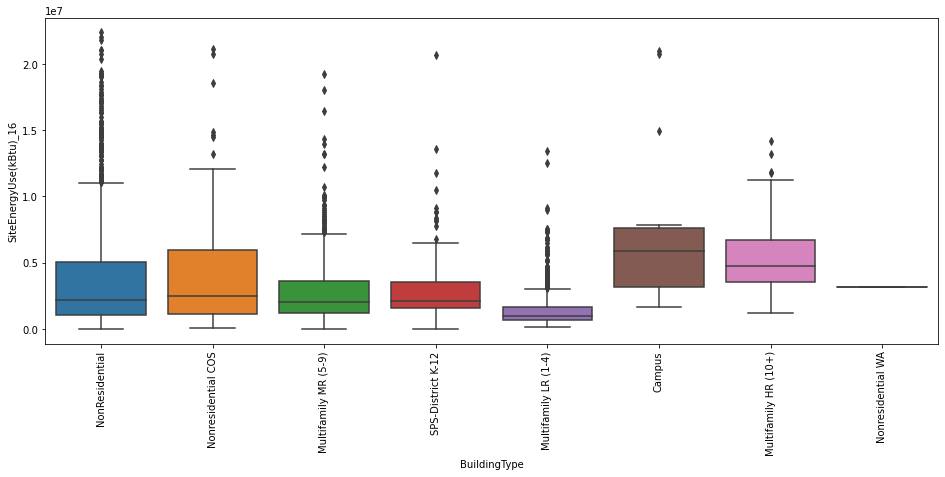

In [64]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=clean_data['BuildingType'], y=clean_data['SiteEnergyUse(kBtu)_16'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


<b> Anova le type de batîment et la consumation d'énergie  </b>

In [65]:
model = ols('Q("SiteEnergyUse(kBtu)_16") ~ BuildingType', data=clean_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F        PR(>F)
BuildingType  4.303154e+15     7.0  61.553689  3.137090e-83
Residual      3.138912e+16  3143.0        NaN           NaN

### Type de la plus grande proprieté Vs Consumation totale d'énerige

[Text(0, 0, 'Hotel'),
 Text(1, 0, 'Other'),
 Text(2, 0, 'Mid-Rise Multifamily'),
 Text(3, 0, 'Mixed Use Property'),
 Text(4, 0, 'K-12 School'),
 Text(5, 0, 'University'),
 Text(6, 0, 'Small- and Mid-Sized Office'),
 Text(7, 0, 'Self-Storage Facility'),
 Text(8, 0, 'Large Office'),
 Text(9, 0, 'Medical Office'),
 Text(10, 0, 'Retail Store'),
 Text(11, 0, 'Low-Rise Multifamily'),
 Text(12, 0, 'Residence Hall'),
 Text(13, 0, 'Warehouse'),
 Text(14, 0, 'Distribution Center'),
 Text(15, 0, 'Senior Care Community'),
 Text(16, 0, 'Worship Facility'),
 Text(17, 0, 'Supermarket / Grocery Store'),
 Text(18, 0, 'Laboratory'),
 Text(19, 0, 'Refrigerated Warehouse'),
 Text(20, 0, 'High-Rise Multifamily'),
 Text(21, 0, 'Restaurant'),
 Text(22, 0, 'Hospital'),
 Text(23, 0, 'Office')]

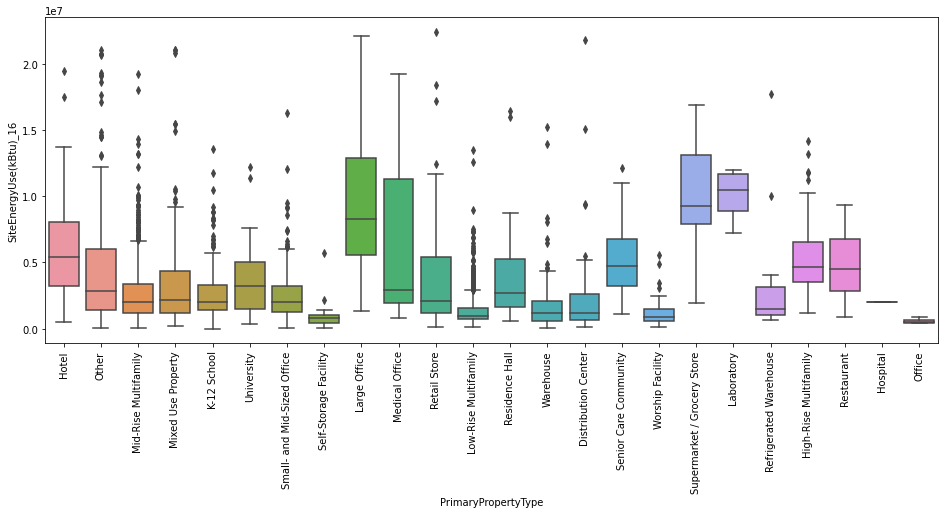

In [66]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=clean_data['PrimaryPropertyType'], y=clean_data['SiteEnergyUse(kBtu)_16'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [67]:
model = ols('Q("SiteEnergyUse(kBtu)_16") ~ PrimaryPropertyType', data=clean_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F         PR(>F)
PrimaryPropertyType  1.237899e+16    23.0  72.190759  2.845969e-268
Residual             2.331329e+16  3127.0        NaN            NaN

### Type de la plus grande proprieté Vs Emission totale de CO2 

[Text(0, 0, 'Hotel'),
 Text(1, 0, 'Other'),
 Text(2, 0, 'Mid-Rise Multifamily'),
 Text(3, 0, 'Mixed Use Property'),
 Text(4, 0, 'K-12 School'),
 Text(5, 0, 'University'),
 Text(6, 0, 'Small- and Mid-Sized Office'),
 Text(7, 0, 'Self-Storage Facility'),
 Text(8, 0, 'Large Office'),
 Text(9, 0, 'Medical Office'),
 Text(10, 0, 'Retail Store'),
 Text(11, 0, 'Low-Rise Multifamily'),
 Text(12, 0, 'Residence Hall'),
 Text(13, 0, 'Warehouse'),
 Text(14, 0, 'Distribution Center'),
 Text(15, 0, 'Senior Care Community'),
 Text(16, 0, 'Worship Facility'),
 Text(17, 0, 'Supermarket / Grocery Store'),
 Text(18, 0, 'Laboratory'),
 Text(19, 0, 'Refrigerated Warehouse'),
 Text(20, 0, 'High-Rise Multifamily'),
 Text(21, 0, 'Restaurant'),
 Text(22, 0, 'Hospital'),
 Text(23, 0, 'Office')]

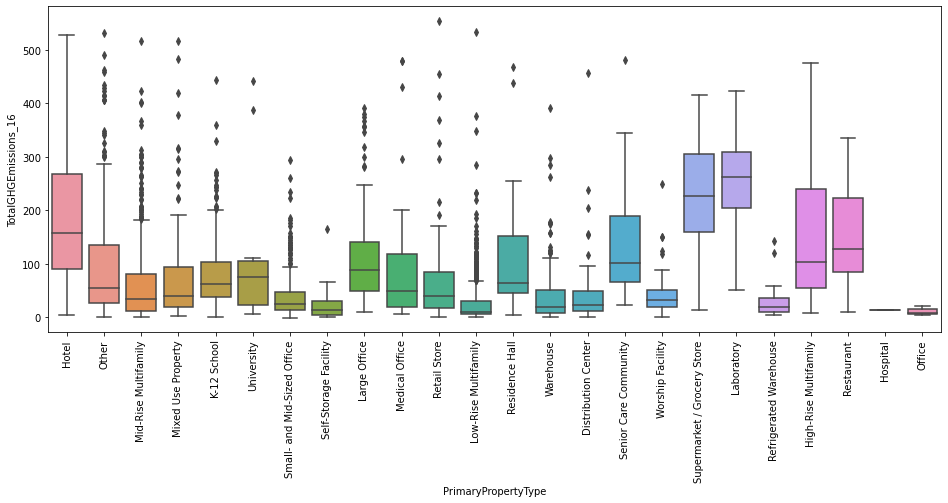

In [71]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(x=clean_data['PrimaryPropertyType'], y=clean_data['TotalGHGEmissions_16'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [72]:
model = ols('Q("TotalGHGEmissions_16") ~ PrimaryPropertyType', data=clean_data).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

sum_sq      df          F         PR(>F)
PrimaryPropertyType  5.536584e+06    23.0  43.424943  6.900936e-169
Residual             1.731198e+07  3123.0        NaN            NaN

## Analyse multivariée

### Matrice de corrélation

In [73]:
clean_data.dtypes

OSEBuildingID                float64
PropertyName                  object
BuildingType                  object
YearBuilt                    float64
NumberofFloors               float64
PropertyGFATotal             float64
NumberofBuildings            float64
PrimaryPropertyType           object
LargestPropertyUseTypeGFA    float64
TotalGHGEmissions_15         float64
TotalGHGEmissions_16         float64
SiteEnergyUse(kBtu)_15       float64
SiteEnergyUse(kBtu)_16       float64
Latitude                     float64
Longitude                    float64
useElectricity                 int32
useNaturalGas                  int32
useSteam                       int32
useOtherFuel                   int32
dtype: object

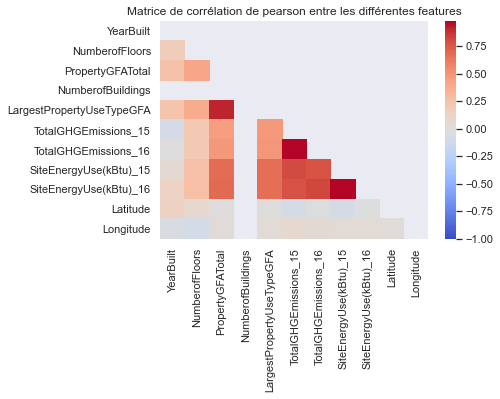

In [74]:
sns.set(font_scale=1)
plt.title('Matrice de corrélation de pearson entre les différentes features')

# Skip first column Building Id
clean_data = clean_data.iloc[:, 1:]
numeric_columns = clean_data.select_dtypes(include = ['int64','float64']).columns

corr = clean_data[numeric_columns].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

<b> Pour les bâtiments non résidentiel : </b>


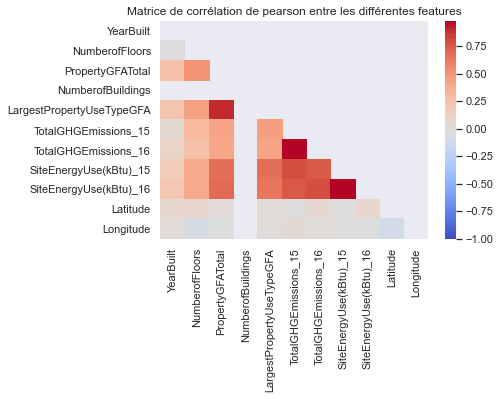

In [75]:
sns.set(font_scale=1)
plt.title('Matrice de corrélation de pearson entre les différentes features')

# Skip first column Building Id
nonResidentialBuilding = nonResidentialBuilding.iloc[:, 1:]
numeric_columns = nonResidentialBuilding.select_dtypes(include = ['int64','float64']).columns

corr = nonResidentialBuilding[numeric_columns].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True 

ax = sns.heatmap(corr, mask=mask, vmin=-1, cmap='coolwarm')
plt.show()
sns.set(font_scale=1)

 # Carte

In [121]:
folium_map = folium.Map(location=[47.608013, -122.335167],
                        zoom_start=11,
                        tiles='CartoDB dark_matter')

for index, row in clean_data[clean_data['Latitude'].notnull() &clean_data['Longitude'].notnull()].iterrows():

    # generate the popup message that is shown on click.
    popup_text = row["PropertyName"]
   

    folium.CircleMarker(location=(row["Latitude"],
                                  row["Longitude"]),
                        radius= row['SiteEnergyUse(kBtu)_16']/1000000,
                        color="#E37222",
                        popup=popup_text,
                        fill=False).add_to(folium_map)
folium_map

# Phase prédictive

In [30]:
buildings = comb_data
buildings = buildings.drop(['PropertyName','PropertyName_lower','OSEBuildingID'],axis=1)
buildings.head(3)

BuildingType  CouncilDistrictCode LargestPropertyUseType  \
0  NonResidential                    7                  Hotel   
1  NonResidential                    7                  Hotel   
2  NonResidential                    7                  Hotel   

   LargestPropertyUseTypeGFA   Latitude   Longitude  NumberofBuildings  \
0                    88434.0  47.612200 -122.337990                1.0   
1                    83880.0  47.613170 -122.333930                1.0   
2                   757243.0  47.623444 -122.334846                1.0   

   NumberofFloors PrimaryPropertyType  PropertyGFAParking  PropertyGFATotal  \
0            12.0               Hotel                   0             88434   
1            11.0               Hotel               15064            103566   
2            41.0               Hotel                   0            961990   

   SecondLargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  TotalGHGEmissions  \
0                     27677.503884            6981428.0             249.43   
1                     15064.000000            8354235.0             263.51   
2                    100000.000000           73130656.0            2061.48   

   YearBuilt  useElectricity  useNaturalGas  useSteam  useOtherFuel  
0       1927               1              1         1             0  
1       1996               1              1         0             0  
2       1969               1              1         1             0

In [31]:
buildings.shape

(6567, 19)

In [32]:
buildings.dtypes

BuildingType                        object
CouncilDistrictCode                  int64
LargestPropertyUseType              object
LargestPropertyUseTypeGFA          float64
Latitude                           float64
Longitude                          float64
NumberofBuildings                  float64
NumberofFloors                     float64
PrimaryPropertyType                 object
PropertyGFAParking                   int64
PropertyGFATotal                     int64
SecondLargestPropertyUseTypeGFA    float64
SiteEnergyUse(kBtu)                float64
TotalGHGEmissions                  float64
YearBuilt                            int64
useElectricity                       int32
useNaturalGas                        int32
useSteam                             int32
useOtherFuel                         int32
dtype: object

In [33]:
categorical_feature_mask = buildings.dtypes==object
categorical_cols = buildings.columns[categorical_feature_mask].tolist()
categorical_cols

['BuildingType', 'LargestPropertyUseType', 'PrimaryPropertyType']

## OneHotEncoder

In [987]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [988]:
final = buildings

final[categorical_cols] = final[categorical_cols].apply(lambda col: le.fit_transform(col.astype(str)))

In [989]:
final.head(2)

BuildingType  CouncilDistrictCode  LargestPropertyUseType  \
0  4             7                    13                       
1  4             7                    13                       

   LargestPropertyUseTypeGFA  Latitude  Longitude  NumberofBuildings  \
0  88434.0                    47.61220 -122.33799  1.0                 
1  83880.0                    47.61317 -122.33393  1.0                 

   NumberofFloors  PrimaryPropertyType  PropertyGFAParking  PropertyGFATotal  \
0  12.0            5                    0                   88434              
1  11.0            5                    15064               103566             

   SecondLargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  TotalGHGEmissions  \
0  27677.503884                     6981428.0            249.43              
1  15064.000000                     8354235.0            263.51              

   YearBuilt  useElectricity  useNaturalGas  useSteam  useOtherFuel  
0  1927       1               1              1         0             
1  1996       1               1              0         0

In [990]:
y = buildings.TotalGHGEmissions

In [991]:
final.isna().sum()

BuildingType                       0
CouncilDistrictCode                0
LargestPropertyUseType             0
LargestPropertyUseTypeGFA          0
Latitude                           0
Longitude                          0
NumberofBuildings                  0
NumberofFloors                     0
PrimaryPropertyType                0
PropertyGFAParking                 0
PropertyGFATotal                   0
SecondLargestPropertyUseTypeGFA    0
SiteEnergyUse(kBtu)                0
TotalGHGEmissions                  0
YearBuilt                          0
useElectricity                     0
useNaturalGas                      0
useSteam                           0
useOtherFuel                       0
dtype: int64

## Using Dummies variables 

In [34]:
dummies = pd.get_dummies(buildings,drop_first=True)

merged = pd.concat([buildings,dummies],axis='columns')

merged.drop(columns=categorical_cols, inplace=True)

final = merged

final = final.loc[:,~final.columns.duplicated()]

In [35]:
final.head(2)

CouncilDistrictCode  LargestPropertyUseTypeGFA  Latitude  Longitude  \
0                    7                    88434.0  47.61220 -122.33799   
1                    7                    83880.0  47.61317 -122.33393   

   NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0            12.0                   0             88434   
1                1.0            11.0               15064            103566   

   SecondLargestPropertyUseTypeGFA  SiteEnergyUse(kBtu)  ...  \
0                     27677.503884            6981428.0  ...   
1                     15064.000000            8354235.0  ...   

   PrimaryPropertyType_SPS-District K-12  \
0                                      0   
1                                      0   

   PrimaryPropertyType_Self-Storage Facility  \
0                                          0   
1                                          0   

   PrimaryPropertyType_Self-Storage Facility\n  \
0                                            0   
1                                            0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   

   PrimaryPropertyType_Small- and Mid-Sized Office  \
0                                                0   
1                                                0   

   PrimaryPropertyType_Supermarket / Grocery Store  \
0                                                0   
1                                                0   

   PrimaryPropertyType_Supermarket/Grocery Store  \
0                                              0   
1                                              0   

   PrimaryPropertyType_University  PrimaryPropertyType_Warehouse  \
0                               0                              0   
1                               0                              0   

   PrimaryPropertyType_Worship Facility  
0                                     0  
1                                     0  

[2 rows x 106 columns]

## Standaridation 

In [36]:
#final.columns

In [37]:
# scaling the inputs 

scaler = MinMaxScaler()

data_rescaled = scaler.fit_transform(final)

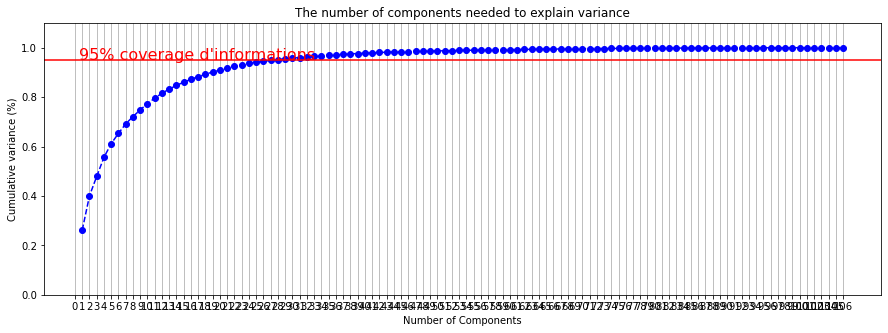

In [38]:
pca = PCA().fit(data_rescaled)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

fig, ax = plt.subplots()
xi = np.arange(1, len(final.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, len(final.columns)+1, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95,color='r', linestyle='-')
plt.text(0.5, 0.95, "95% coverage d'informations", color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

## Modèles Machine learning

In [39]:
X = final.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'], axis=1)
X.head(3)

CouncilDistrictCode  LargestPropertyUseTypeGFA   Latitude   Longitude  \
0                    7                    88434.0  47.612200 -122.337990   
1                    7                    83880.0  47.613170 -122.333930   
2                    7                   757243.0  47.623444 -122.334846   

   NumberofBuildings  NumberofFloors  PropertyGFAParking  PropertyGFATotal  \
0                1.0            12.0                   0             88434   
1                1.0            11.0               15064            103566   
2                1.0            41.0                   0            961990   

   SecondLargestPropertyUseTypeGFA  YearBuilt  ...  \
0                     27677.503884       1927  ...   
1                     15064.000000       1996  ...   
2                    100000.000000       1969  ...   

   PrimaryPropertyType_SPS-District K-12  \
0                                      0   
1                                      0   
2                                      0   

   PrimaryPropertyType_Self-Storage Facility  \
0                                          0   
1                                          0   
2                                          0   

   PrimaryPropertyType_Self-Storage Facility\n  \
0                                            0   
1                                            0   
2                                            0   

   PrimaryPropertyType_Senior Care Community  \
0                                          0   
1                                          0   
2                                          0   

   PrimaryPropertyType_Small- and Mid-Sized Office  \
0                                                0   
1                                                0   
2                                                0   

   PrimaryPropertyType_Supermarket / Grocery Store  \
0                                                0   
1                                                0   
2                                                0   

   PrimaryPropertyType_Supermarket/Grocery Store  \
0                                              0   
1                                              0   
2                                              0   

   PrimaryPropertyType_University  PrimaryPropertyType_Warehouse  \
0                               0                              0   
1                               0                              0   
2                               0                              0   

   PrimaryPropertyType_Worship Facility  
0                                     0  
1                                     0  
2                                     0  

[3 rows x 104 columns]

In [40]:
y = final.TotalGHGEmissions
y

0        249.43
1        263.51
2       2061.48
3       1936.34
4        507.70
         ...   
6715       8.70
6716      31.46
6717     395.26
6718       5.46
6719       6.74
Name: TotalGHGEmissions, Length: 6567, dtype: float64

In [41]:
y.shape

(6567,)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
lm = LinearRegression().fit(X_train, y_train) 
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
  
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train) 
y_predict = lm.predict(X_test) 
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 
y_predict_dummy_median = lm_dummy_median.predict(X_test) 

In [43]:
print("\nMean squared error (dummy): {:.2f}".format(mean_squared_error(y_test,                                                                   y_predict_dummy_mean))) 
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))

print("\nMedian absolute error (dummy): {:.2f}".format(median_absolute_error(y_test,y_predict_dummy_median))) 
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict))) 
  
print("\nr2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean))) 
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median))) 
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict))) 


Mean squared error (dummy): 131264.36
Mean squared error (linear model): 47433.04

Median absolute error (dummy): 27.32
Median absolute error (linear model): 35.69

r2_score (dummy mean): -0.00
r2_score (dummy median): -0.03
r2_score (linear model): 0.64


In [44]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lm, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [45]:
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Paramters Random forest regressor
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 400, num = 2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 60, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]


model_params = {
    'Ridge': {
            'model': Ridge(),
            'params' : {
                'alpha':[1,0.1,0.01,0.001,0,10,200,50,500],
                'fit_intercept': [True,False]
            }
        },
    'LinearRegression':{
        'model':LinearRegression(),
        'params': {
            'fit_intercept':[True,False], 
            'normalize':[True,False], 
            'copy_X':[True, False]
        }
    },
    'Lasso' : {
        'model': Lasso(),
        'params': {
            'alpha':[1,0.1,0.01,0.001,0,10,200,50,500],
            'fit_intercept': [True,False],
            'normalize':[True,False]
        }
    },
}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# To display the whole row 
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])


D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37262e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.10558e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.4994e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49557e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.77762e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packag

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125725919.8316788, tolerance: 76993.56731035221
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123984718.84544891, tolerance: 77676.57560429284
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117823908.98974594, tolerance: 79481.73663774283
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to incre

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122796904.23649286, tolerance: 79632.18999305285
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121604163.53677718, tolerance: 76993.56731035221
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119626733.8226242, tolerance: 77676.57560429284
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to incre

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122653045.08608717, tolerance: 74365.41544184806
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121458927.33778037, tolerance: 71591.5772143882
  model 

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121525474.6068793, tolerance: 76993.56731035221
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223703077.7837553, tolerance: 77676.57560429284
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222587170.07268777, tolerance: 79632.18999305285
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increa

In [46]:
df

model  best_score  \
0  Ridge             0.634739     
1  LinearRegression  0.633093     
2  Lasso             0.623720     

                                                   best_params  
0  {'alpha': 1, 'fit_intercept': False}                         
1  {'copy_X': True, 'fit_intercept': True, 'normalize': False}  
2  {'alpha': 0.1, 'fit_intercept': False, 'normalize': True}

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


parameters = {
    'n_estimators' : [10,50,100,300,500], 
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt'] 
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


rfr_search = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                              verbose=2,
                               cv=5)

rfr_search.fit(X_train, y_train)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.7s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.6s
[CV] max_features=auto, min_samples_leaf=1

[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.7s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.7s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.7s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.4s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.4s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.3s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.3s
[CV] max_features=auto, min_samples_le

[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=100, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=100, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.1s
[CV] max_features=sqrt, min_samples

[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=300, total=   1.9s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   3.0s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.7s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=10 .........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=10, total=   0.0s
[CV] max_features=sqrt, min_samples

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 14.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [48]:
rfr_search.best_params_

{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}

In [49]:
rfr_search.best_score_

0.8160165790736755

<b> Prédication de consumation d'énergie </b>

In [50]:
y = final['SiteEnergyUse(kBtu)']

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) 
lm = LinearRegression().fit(X_train, y_train) 
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train) 
  
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train) 
y_predict = lm.predict(X_test) 
y_predict_dummy_mean = lm_dummy_mean.predict(X_test) 
y_predict_dummy_median = lm_dummy_median.predict(X_test) 

In [52]:
print("\nMean squared error (dummy): {:.2f}".format(mean_squared_error(y_test,                                                                   y_predict_dummy_mean))) 
print("Mean squared error (linear model): {:.2f}".format(mean_squared_error(y_test, y_predict)))

print("\nMedian absolute error (dummy): {:.2f}".format(median_absolute_error(y_test,y_predict_dummy_median))) 
print("Median absolute error (linear model): {:.2f}".format(median_absolute_error(y_test, y_predict))) 
  
print("\nr2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean))) 
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median))) 
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict))) 


Mean squared error (dummy): 108902742203438.03
Mean squared error (linear model): 31253499323290.74

Median absolute error (dummy): 1081571.50
Median absolute error (linear model): 1101915.16

r2_score (dummy mean): -0.00
r2_score (dummy median): -0.07
r2_score (linear model): 0.71


In [53]:
from sklearn.metrics import plot_confusion_matrix


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_params = {
    'Ridge': {
            'model': Ridge(),
            'params' : {
                'alpha':[1,0.1,0.01,0.001,0,10,200,50,500],
                'fit_intercept': [True,False]
            }
        },
    'LinearRegression':{
        'model':LinearRegression(),
        'params': {
            'fit_intercept':[True,False], 
            'normalize':[True,False], 
            'copy_X':[True, False]
        }
    },
    'Lasso' : {
        'model': Lasso(),
        'params': {
            'alpha':[1,0.1,0.01,0.001,0,10,200,50,500],
            'fit_intercept': [True,False],
            'normalize':[True,False]
        }
    },

}

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# To display the whole row 
pd.set_option('display.max_colwidth', -1)

df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.37262e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.10558e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.4994e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.49557e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.77762e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
D:\Anconda\lib\site-packag

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0728819216984322e+17, tolerance: 100041208595373.34
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.690447479700608e+16, tolerance: 97159495533795.0
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0828649695551162e+17, tolerance: 98913951420850.61
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might w

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0751680475263179e+17, tolerance: 80100825855907.25
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0722014825685949e+17, tolerance: 88790626168135.94
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.679752005852619e+16, tolerance: 86464336669900.8
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might wa

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.063975609078987e+17, tolerance: 93715071632869.69
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0788357155817611e+17, tolerance: 91189483485780.39
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0728490909790189e+17, tolerance: 100041208595373.34
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might 

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0628731308397472e+17, tolerance: 82795763397486.83
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0780092056667424e+17, tolerance: 80100825855907.25

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.078835688307641e+17, tolerance: 91189483485780.39
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 590350194373728.0, tolerance: 88790626168135.94
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92142201085728.0, tolerance: 86464336669900.8
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to incre

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0785590259115874e+17, tolerance: 100041208595373.34
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.743252658727443e+16, tolerance: 97159495533795.0
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0882114977959947e+17, tolerance: 98913951420850.61
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might w

D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0859388649211618e+17, tolerance: 100041208595373.34
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.815170793585301e+16, tolerance: 97159495533795.0
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0954264398184835e+17, tolerance: 98913951420850.61
  model = cd_fast.enet_coordinate_descent(
D:\Anconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might w

In [54]:
df

model  best_score  \
0  Ridge             0.693117     
1  LinearRegression  0.682855     
2  Lasso             0.680171     

                                                   best_params  
0  {'alpha': 1, 'fit_intercept': True}                          
1  {'copy_X': True, 'fit_intercept': True, 'normalize': False}  
2  {'alpha': 500, 'fit_intercept': True, 'normalize': False}

In [55]:
parameters = {
    'n_estimators' : [10,50,100,300,500], 
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt'] 
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


rfr_search = GridSearchCV(RandomForestRegressor(),
                               param_grid = parameters,
                              verbose=2,
                               cv=5)

rfr_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=10 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=10, total=   0.5s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.4s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.4s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=50, total=   2.5s
[CV] max_features=auto, min_samples_leaf=1

[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=50 ..........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=50, total=   1.5s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.1s
[CV] max_features=auto, min_samples_leaf=5, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=5, n_estimators=100, total=   3.1s
[CV] max_features=auto, min_samples_le

[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=100, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=100, total=   1.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=300 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=300, total=   3.0s
[CV] max_features=sqrt, min_samples

[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=300, total=   1.5s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.6s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   2.8s
[CV] max_features=sqrt, min_samples_leaf=5, n_estimators=500 .........
[CV]  max_features=sqrt, min_samples_leaf=5, n_estimators=500, total=   3.1s
[CV] max_features=sqrt, min_samples_leaf=10, n_estimators=10 .........
[CV]  max_features=sqrt, min_samples_leaf=10, n_estimators=10, total=   0.1s
[CV] max_features=sqrt, min_samples

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.5min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=2)

In [56]:
rfr_search.best_params_


{'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 300}

In [57]:
rfr_search.best_score_

0.8171828002555603